# Variational Autoencoder with MSE as Reconstruction Loss Term

The motivating principle behind this experiment is that, while mathematically rigorous, the reconstruction likelihood loss function might be overly complex for the actual performance of VAE's for certain tasks. The true power of VAE's is their power to drive meaningful latent spaces by spreading the values out for a given input and in that way, the spaces in between each memorized point will be meaningful. 

This experiment hypothesizes that the VAE will perform better with a good ole fashioned MSE loss function as a reconstruction term so long as we keep the KL Divergence to drive the distribution of the latent layer to a standard normal. 


## Input info 

In [135]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

raw_data = pd.read_csv("./data/Movielens100/u.data", sep = None, names=["userId", "movieId", "rating", "timestamp"])
raw_data = raw_data.loc[:, raw_data.columns != "timestamp"]
#make indices start at 0
raw_data["userId"] -= 1
raw_data["movieId"] -= 1
#make ratings center around 0
raw_data["rating"] -= 3

# create (943, 1682) matrix of user ratings per movie
user_ratings = pd.DataFrame(np.zeros((943,1682)))
for i in raw_data.index:
    user_ratings[raw_data["movieId"][i]][raw_data["userId"][i]] = raw_data["rating"][i]
user_ratings = user_ratings.to_numpy() 
np.random.shuffle(user_ratings)
user_ratings

C:\Users\leuch\AppData\Local\Temp\ipykernel_2604\2468113692.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv("./data/Movielens100/u.data", sep = None, names=["userId", "movieId", "rating", "timestamp"])


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Begin model and tuning of Hyperparameters

In [147]:
from torch.utils.data import Dataset, DataLoader
from torch import nn 
import torch
from sklearn.metrics import precision_recall_fscore_support
device = "cuda"

class MovielensDataset(Dataset):
    def __init__(self, data, mask_magnitude):
        self.data = data
        # create a mask of 0 and 1 values where half are 0 and half are 1. 
        #The ratio of masked values is something that can and should be optimized. 
        self.random_mask = np.clip((np.random.randn(1682) + mask_magnitude).round(), a_max = 1, a_min = 0)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        np.random.shuffle(self.random_mask)
        return self.data[idx] * self.random_mask, self.data[idx]


class VariationalAutoEncoder(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.encoder = nn.Sequential(
            #Encoder
            nn.Linear(1682, 1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024,1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
        )
        self.decoder = nn.Sequential(
            #Decoder
            nn.Linear(512,1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024,1682),
            nn.Tanh()
        )
        # distribution parameters
        self.fc_mu = nn.Linear(1024, 512)
        self.fc_var = nn.Linear(1024, 512)
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        #for evaluation purposes
        self.test_mse = 1000
        
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing data under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=1)
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def forward(self, x):
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        
        #perform the kernel trick to allow for backprop through sampling
        
        epsilon = torch.distributions.Normal(0, 1).rsample()
        z = mu + epsilon * std
        # decoded
        ratings = self.decoder(z) * 2
        return ratings, z, mu, std
    
    def vae_loss(self, x_hat, x, z, mu, std):
        # reconstruction loss. This is now MSE instead of gaussian likelihood
        #indies = x.nonzero().split(1, dim=1)
        
        #recon_loss = ((x[indies] - x_hat[indies]) ** 2).sum() 
        recon_loss = mse_loss_fcn(x_hat, x) * 10000#self.gaussian_likelihood(x_hat, self.log_scale, x)
        
        # kl
        kl = self.kl_divergence(z, mu, std)
        # elbo
        elbo = (kl + recon_loss).mean()

        return elbo

def train(dataloader, model,  optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        #compute prediction error
        pred, z, mu, std = model(X)
        loss = model.vae_loss(pred, y, z, mu, std)
        mse_loss = mse_loss_fcn(pred, y)
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0 and batch % 64 == 0:
            loss , current = loss.item(), (batch+1) * len(X)
            print("Epoch : " + str(epoch))
            print(f"loss: {loss:>7f}")
            print(f"MSE loss: {mse_loss:>7f}")
            losses.append(loss)
            mse_losses.append(mse_loss.item())

def test(dataloader, model, epoch):
    size = len(dataloader.dataset)
    num_batches= len(dataloader)
    model.eval()
    test_loss, correct, test_mse_loss = 0,0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            
            
            pred, z, mu, std = model(X)
            test_loss += model.vae_loss(pred, y, z, mu, std).item()
            test_mse_loss += mse_loss_fcn(pred, y)
    test_loss /= num_batches
    test_mse_loss /= num_batches
    if epoch % 100 ==0:
        test_losses.append(test_loss)
        #Come back and actually do the accuracy where it sees if it's at least on the right side of it or compute precision/recall or something like that
        print(f"Test Error: \n Avg Loss : {test_loss:>8f} ")
        print(f" Test MSE loss: {test_mse_loss:>7f}")
        test_mse_losses.append(test_mse_loss.item())
        model.test_mse = test_mse_loss.item()
        
        
        

## The actual search 
The following contains all of the logic you need to do to restart everything over so long as you've already loaded the ones above

In [148]:
epochs = 2000
lowest_test_mse_score = 1000
mask_magnitude = 1.3
#Search 
l2_weight = 0
dropout_rate = 0
random_mask = np.clip((np.random.randn(1682) + mask_magnitude).round(), a_max = 1, a_min = 0)
print("using hyperparameters : " + str( l2_weight) + " , " + str(dropout_rate))
train_dataset = MovielensDataset(user_ratings[:843], mask_magnitude)
test_dataset = MovielensDataset(user_ratings[843:], mask_magnitude)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)


losses = []
mse_losses = []    
test_losses = []
test_mse_losses = []

model = VariationalAutoEncoder(dropout_rate = dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = l2_weight)
mse_loss_fcn = nn.MSELoss()

for t in range(epochs):
    train(train_dataloader, model,  optimizer, t)
    test(test_dataloader, model, t )
    if t % 100 == 0:
        if model.test_mse < lowest_test_mse_score:
            lowest_test_mse_score = model.test_mse
            torch.save(model.state_dict(), "./models/best.pth")
            print("New best using hyper parameters : " + str(mask_magnitude) + " ," + str(l2_weight) + " ," + str(dropout_rate)  )

using hyperparameters : 0 , 0
Epoch : 0
loss: 1677.984253
MSE loss: 0.167762
Test Error: 
 Avg Loss : 841.477966 
 Test MSE loss: 0.083582
New best using hyper parameters : 1.3 ,0 ,0
Epoch : 100
loss: 564.501709
MSE loss: 0.049036
Test Error: 
 Avg Loss : 541.203369 
 Test MSE loss: 0.063605
New best using hyper parameters : 1.3 ,0 ,0
Epoch : 200
loss: 331.785950
MSE loss: 0.029802
Test Error: 
 Avg Loss : 638.581482 
 Test MSE loss: 0.061719
New best using hyper parameters : 1.3 ,0 ,0
Epoch : 300
loss: 283.131073
MSE loss: 0.018463
Test Error: 
 Avg Loss : 599.761658 
 Test MSE loss: 0.054042
New best using hyper parameters : 1.3 ,0 ,0
Epoch : 400
loss: 154.640137
MSE loss: 0.023778
Test Error: 
 Avg Loss : 581.161560 
 Test MSE loss: 0.054158
Epoch : 500
loss: 179.367706
MSE loss: 0.013317
Test Error: 
 Avg Loss : 582.132202 
 Test MSE loss: 0.054019
New best using hyper parameters : 1.3 ,0 ,0
Epoch : 600
loss: 128.329926
MSE loss: 0.010426
Test Error: 
 Avg Loss : 583.815613 
 Test 

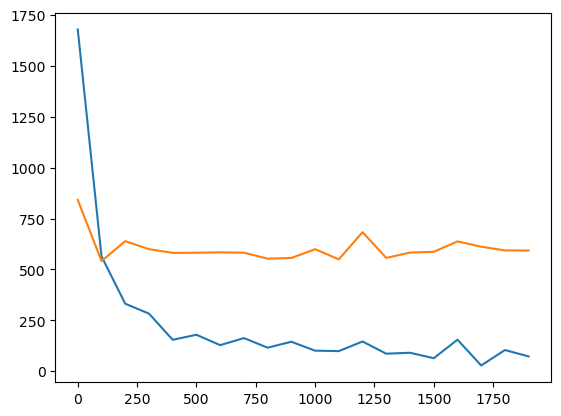

In [149]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)) * 100, losses)
plt.plot(np.arange(len(test_losses)) * 100, test_losses)

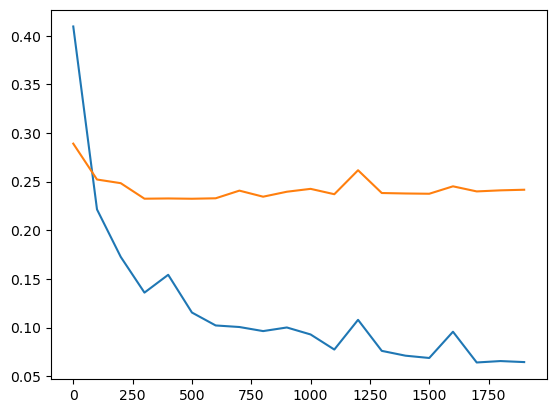

In [150]:
plt.plot(np.arange(len(mse_losses)) * 100, np.sqrt(np.array(mse_losses)))
plt.plot(np.arange(len(test_mse_losses)) * 100, np.sqrt(np.array(test_mse_losses)))

# Calculate Precision and Recall

In [152]:
model = VariationalAutoEncoder(dropout_rate = 0).to(device)
model.load_state_dict(torch.load("./models/best.pth"))
model.eval()
relevance_labels = user_ratings[843:] > 0.5
#To evaluate for comparison to other papers we mask by setting 20% of labels to false 
test_inputs = np.clip((np.random.randn(1682) + 1.35).round(), a_max = 1, a_min = 0) * user_ratings[843:]
test_preds = model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0] > 0.4

precision_recall_fscore_support(relevance_labels.flatten(), test_preds.cpu().flatten(), average="binary")

(0.600154231733179, 0.6072961373390557, 0.6037040628333171, None)

# Calculate RMSE

In [173]:
nonzero_indices = torch.tensor(test_inputs).to("cuda").nonzero().split( 1, dim=1)
torch.sqrt(((torch.tensor(test_inputs).to("cuda")[nonzero_indices] - model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0][nonzero_indices]) ** 2).mean())

tensor(0.9481, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)

## Conclusion:
The result is that I was, in fact, mistaken and that the MSE was less suited to the task than the usual Gaussian Likelihood

(array([0.0000e+00, 2.4000e+01, 3.4000e+01, 1.2238e+04, 6.6582e+04,
        6.8248e+04, 1.9639e+04, 5.7600e+02, 8.4400e+02, 1.5000e+01]),
 array([-2.1, -1.9, -1.1, -0.9, -0.1,  0. ,  0.1,  0.9,  1.1,  1.9,  2.1]),
 <BarContainer object of 10 artists>)

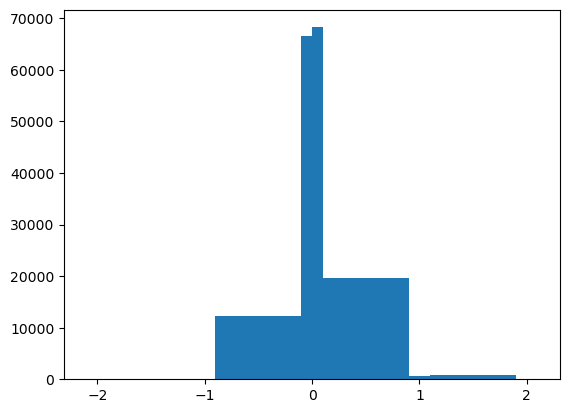

In [153]:
import matplotlib.pyplot as plt
plt.hist(model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0].cpu().detach().numpy().flatten(), bins = [-2.1, -1.9, -1.1, -0.9, -.1, 0, .1, .9, 1.1, 1.9, 2.1])

(array([   486.,      0.,    887.,      0.,      0., 162715.,      0.,
          2664.,      0.,   1448.]),
 array([-2.1, -1.9, -1.1, -0.9, -0.1,  0. ,  0.1,  0.9,  1.1,  1.9,  2.1]),
 <BarContainer object of 10 artists>)

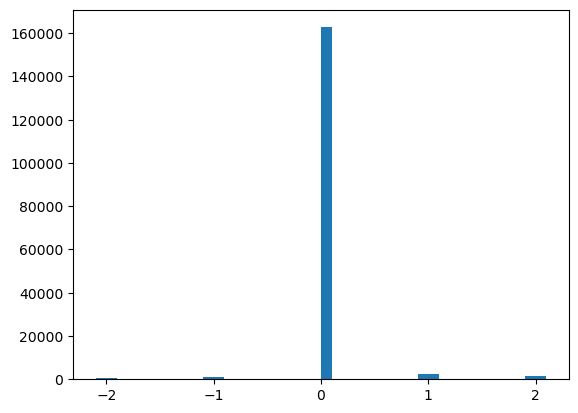

In [154]:
plt.hist(test_inputs.flatten(), bins = [-2.1, -1.9, -1.1, -0.9, -.1, 0, .1, .9, 1.1, 1.9, 2.1])